# Home Credit Default Risk
###  Final Project for MATH5470: Statistical Machine Learning
###  Hui, Chun (12284238)  

## Introduction

For this classification problem, I try to use logistic regression and lightgbm model. The analysis process will be divided to the following parts: 

(1) Data Analysis (data visualization and using histograms to give a firstsight for the relationship between labels (TARGET) and other features.)

(2) Data cleaning and processing. I use two forms 'application_train.csv' and 'application_test.csv' to analysis. That is because they have about 120 features and make up more than half of the features in file 'HomeCredit_columns_description.csv', which is adequate for attempting a ML model. I mainly deal with the missing values and features with extramely large values which have many outliers.

(3) Feature Construction. I manually construct some more features according to domain knowledge.

(4) Build models and given predictions. In this process, I analyze the importances of features, using AUC, precision, specificity and sensitivity to evaluate models. 

First, import packages that used.

In [3]:
import numpy as np 
import pandas as pd 
import os 
import warnings 
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.misc import derivative

## 1. Data Visualization
### 1.1  Features

In [4]:
# Load raw data in 'application_train.csv' and 'application_test.csv'
dt_train = pd.read_csv('./data/application_train.csv') 
dt_test = pd.read_csv('./data/application_test.csv') 
print(dt_train.shape,dt_test.shape) 

(307511, 122) (48744, 121)


Training data has 307 thousand samples and testing data has nearly 50 thousand samples, they both have 121 features. (training set has "TARGET").

In [5]:
# print application training set
dt_train.head(10)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   
8      100011       0         Cash loans           F            N   
9      100012       0    Revolving loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   
8               Y             0          112500.0   1019610.0      33826.5   
9               Y             0          135000.0    405000.0      20250.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   
5  ...                 0                0                0                0   
6  ...                 0                0                0                0   
7  ...                 0                0                0                0   
8  ...                 0                0                0                0   
9  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   
5                        0.0                       0.0   
6                        0.0                       0.0   
7                        0.0                       0.0   
8                        0.0                       0.0   
9                        NaN                       NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   
5                         0.0                        0.0   
6                         0.0                        1.0   
7                         0.0                        0.0   
8                         0.0                        0.0   
9                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0         

In [6]:
dt_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e+05   
mean   5.990260e+05   27108.573909     5.383962e+05   
std    4.024908e+05   14493.737315     3.694465e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  ...  \
count               307511.000000  307511.000000  307511.000000  ...   
mean                     0.020868  -16036.995067   63815.045904  ...   
std                      0.013831    4363.988632  141275.766519  ...   
min                      0.000290  -25229.000000  -17912.000000  ...   
25%                      0.010006  -19682.000000   -2760.000000  ...   
50%                      0.018850  -15750.000000   -1213.000000  ...   
75%                      0.028663  -12413.000000    -289.000000  ...   
max                      0.072508   -7489.000000  365243.000000  ...   

       FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count     307511.000000     307511.000000     307511.000000     307511.000000   
mean           0.008130          0.000595          0.000507          0.000335   
std            0.089798          0.024387          0.022518          0.018299   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count               265992.000000              265992.000000   
mean                     0.006402                   0.007000   
std                      0.083849                   0.110757   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      4.000000                   9.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count               265992.000000              265992.000000   
mean                     0.034362                   0.267395   
std                      0.204685                   0.916002   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      8.000000                  27.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count              265992.000000               265992.000000  
mean                    0.265474                    1.899974  
std                     0.794056                    1.869295  
min                     0.000000                    0.000000  
25%              

In [7]:
# print application testing set
dt_test.head(10)

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   
5      100042         Cash loans           F            Y               Y   
6      100057         Cash loans           M            Y               Y   
7      100065         Cash loans           M            N               Y   
8      100066         Cash loans           F            N               Y   
9      100067         Cash loans           F            Y               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   
5             0          270000.0    959688.0      34600.5         810000.0   
6             2          180000.0    499221.0      22117.5         373500.0   
7             0          166500.0    180000.0      14220.0         180000.0   
8             0          315000.0    364896.0      28957.5         315000.0   
9             1          162000.0     45000.0       5337.0          45000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   
5  ...                0                0                0                0   
6  ...                0                0                0                0   
7  ...                0                0                0                0   
8  ...                0                0                0                0   
9  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   
5                        0.0                        0.0   
6                        0.0                        0.0   
7                        0.0                        0.0   
8                        0.0                        0.0   
9                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   
5                         0.0                        0.0   
6                         0.0                        0.0   
7                         0.0                        0.0   
8                         0.0                        0.0   
9                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0

In [8]:
dt_test.describe()

SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count   48744.000000  48744.000000      4.874400e+04  4.874400e+04   
mean   277796.676350      0.397054      1.784318e+05  5.167404e+05   
std    103169.547296      0.709047      1.015226e+05  3.653970e+05   
min    100001.000000      0.000000      2.694150e+04  4.500000e+04   
25%    188557.750000      0.000000      1.125000e+05  2.606400e+05   
50%    277549.000000      0.000000      1.575000e+05  4.500000e+05   
75%    367555.500000      1.000000      2.250000e+05  6.750000e+05   
max    456250.000000     20.000000      4.410000e+06  2.245500e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count   48720.000000     4.874400e+04                48744.000000   
mean    29426.240209     4.626188e+05                    0.021226   
std     16016.368315     3.367102e+05                    0.014428   
min      2295.000000     4.500000e+04                    0.000253   
25%     17973.000000     2.250000e+05                    0.010006   
50%     26199.000000     3.960000e+05                    0.018850   
75%     37390.500000     6.300000e+05                    0.028663   
max    180576.000000     2.245500e+06                    0.072508   

         DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  ...  FLAG_DOCUMENT_18  \
count  48744.000000   48744.000000       48744.000000  ...      48744.000000   
mean  -16068.084605   67485.366322       -4967.652716  ...          0.001559   
std     4325.900393  144348.507136        3552.612035  ...          0.039456   
min   -25195.000000  -17463.000000      -23722.000000  ...          0.000000   
25%   -19637.000000   -2910.000000       -7459.250000  ...          0.000000   
50%   -15785.000000   -1293.000000       -4490.000000  ...          0.000000   
75%   -12496.000000    -296.000000       -1901.000000  ...          0.000000   
max    -7338.000000  365243.000000           0.000000  ...          1.000000   

       FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  \
count           48744.0           48744.0           48744.0   
mean                0.0               0.0               0.0   
std                 0.0               0.0               0.0   
min                 0.0               0.0               0.0   
25%                 0.0               0.0               0.0   
50%                 0.0               0.0               0.0   
75%                 0.0               0.0               0.0   
max                 0.0               0.0               0.0   

       AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
count                42695.000000               42695.000000   
mean                     0.002108                   0.001803   
std                      0.046373                   0.046132   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                   2.000000   

       AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
count                42695.000000               42695.000000   
mean                     0.002787                   0.009299   
std                      0.054037                   0.110924   
min                      0.000000                   0.000000   
25%                      0.000000                   0.000000   
50%                      0.000000                   0.000000   
75%                      0.000000                   0.000000   
max                      2.000000                   6.000000   

       AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
count               42695.000000                42695.000000  
mean                    0.546902                    1.983769  
std                     0.693305                    1.838873  
min                     0.000000                    0.000000  

In [9]:
# print the data type and numbers of each type of training and testing set.
print(dt_train.dtypes.value_counts(),dt_test.dtypes.value_counts())

float64    65
int64      41
object     16
dtype: int64 float64    65
int64      40
object     16
dtype: int64


From the above print results and statistics, there are various types of data, including numerical values, integers and categories. Different types of data need different methods to deal with. Firstly, deal with the missing values (details will be shown in the followings). 

For numerical values with float and integer data type, use median value of this feature to fill in. For data of object type, use dummy variables to split one feature to several features, and each of the new feature is a vector made up by 0 or 1. Also, there are features with extremely large values. For this kind of features, manually check if there are outliers.


### 1.2  TARGET Distribution Analysis

0    282686
1     24825
Name: TARGET, dtype: int64

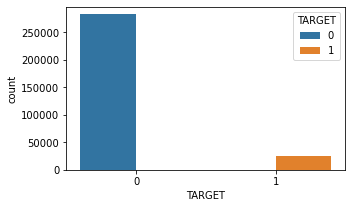

In [10]:
# plot the distribution of 'TARGET' labels of training set.
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(x ='TARGET',data=dt_train, hue='TARGET')
dt_train.TARGET.value_counts()

In [11]:
24825/307511

0.08072881945686496

The target labels are very imbalanced. Just 8% targets value 1.

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

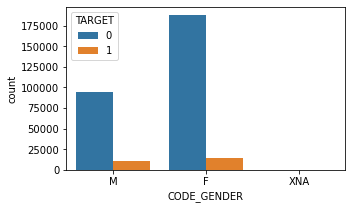

In [12]:
# plot the distribution of 'TARGET' labels of training set with different genders.
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(x='CODE_GENDER',data=dt_train,hue='TARGET')
dt_train.CODE_GENDER.value_counts()

In [13]:
s1=dt_train[dt_train['CODE_GENDER']=='F' ]  # number of females
s1[s1['TARGET']==0]['TARGET'].count()  # number of target=0 in females: 188278
s1[s1['TARGET']==1]['TARGET'].count()  # number of target=1 in females: 14170
s2=dt_train[dt_train['CODE_GENDER']=='M' ]  # number of males
s2[s2['TARGET']==0]['TARGET'].count()  # number of target=0 in males: 94404
s2[s2['TARGET']==1]['TARGET'].count()  # number of target=0 in males: 10655
# 14170/202448=7.0% the percentage of target=1 in females
# 10655/105059=10.1%  the percentage of target=1 in males

10655

The percentage of target=1 in males is 10.1% and in females is 7.0%. Men have a larger percentage of TARGET 1 than women, which means men have more percentage of people having difficults paying. Gender has somehow effects on the targets.

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64

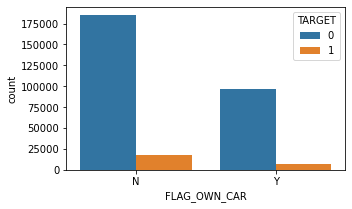

In [14]:
# plot the distribution of 'TARGET' labels of training set with whether the clients owning cars.
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(x='FLAG_OWN_CAR', data=dt_train, hue='TARGET') 
dt_train.FLAG_OWN_CAR.value_counts()

In [15]:
s1=dt_train[dt_train['FLAG_OWN_CAR']=='Y' ]  # number of clients owning cars
s1[s1['TARGET']==0]['TARGET'].count()  # number of target=0 in clients owning cars: 97011
s1[s1['TARGET']==1]['TARGET'].count()  # number of target=1 in clients owning cars: 7576
s2=dt_train[dt_train['FLAG_OWN_CAR']=='N' ]  # number of clients not owning cars
s2[s2['TARGET']==0]['TARGET'].count()  # number of target=0 in clients not owning cars: 185675
s2[s2['TARGET']==1]['TARGET'].count()  # number of target=0 in clients not owning cars: 17249
# 7576/104587=7.2% the percentage of target=1 in clients owning cars
# 17249/202924=8.5%  the percentage of target=1 in clients not owning cars

17249

The percentage of target=1 in clients owning cars is 7.2% and in clients not owning cars is 8.5%. The difference is slight, so intuitively thinking whether owning cars may not have much influence on the targets. It's consistent with the common sense that the client who owns a car is basically richer than who doesn't own cars, so the latter ones are easier to have payment difficulties.

<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

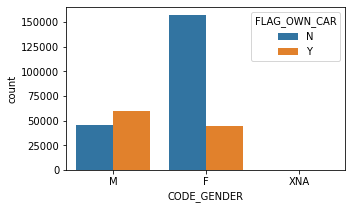

In [16]:
# plot the distribution of 'FLAG_OWN_CAR' labels of training set with different genders.
fig, ax = plt.subplots(figsize=(5,3))
sns.countplot(x='CODE_GENDER', data=dt_train, hue='FLAG_OWN_CAR')

It's obvious that the percentage of owning cars in men is substantially larger than women.

## 2.  Data processing
### 2.1  Missing values
First, calculate the percentage of missing values of each feature in application train and test set. Second, sort them and delete the features with missing percentage larger than 60%.

In [17]:
# calculate missing value percentages
def calculate_missing_values(df): 
    missing_total = df.isnull().sum() # total missing values 
    missing_percent = missing_total / len(df)*100 # percentage of missing values 
    missing_stats = pd.concat([missing_total, missing_percent], axis=1)  # form missing value table
    missing_stats = missing_stats.rename(columns = {0 : 'Number of Missing Values', 1 : 'Percentage'}) # column names 
    missing_stats = missing_stats[missing_stats.iloc[:,1] != 0].sort_values( 'Percentage', ascending=False).round(2) # sort the table by percentage of missing descending
    return missing_stats

In [18]:
# calculate the tables of missing values for application train and test data.
missing_values_train = calculate_missing_values(dt_train) 
missing_values_test = calculate_missing_values(dt_test)
print(len(missing_values_train),len(missing_values_test))

67 64


There are 67 and 64 features that have missing values in application train and test set, respectively. About half of the features are incomplete.

In [19]:
# print the top 20 features with largest percentage of missing values
missing_values_train.head(20)

Number of Missing Values  Percentage
COMMONAREA_MEDI                             214865       69.87
COMMONAREA_AVG                              214865       69.87
COMMONAREA_MODE                             214865       69.87
NONLIVINGAPARTMENTS_MEDI                    213514       69.43
NONLIVINGAPARTMENTS_MODE                    213514       69.43
NONLIVINGAPARTMENTS_AVG                     213514       69.43
FONDKAPREMONT_MODE                          210295       68.39
LIVINGAPARTMENTS_MODE                       210199       68.35
LIVINGAPARTMENTS_MEDI                       210199       68.35
LIVINGAPARTMENTS_AVG                        210199       68.35
FLOORSMIN_MODE                              208642       67.85
FLOORSMIN_MEDI                              208642       67.85
FLOORSMIN_AVG                               208642       67.85
YEARS_BUILD_MODE                            204488       66.50
YEARS_BUILD_MEDI                            204488       66.50
YEARS_BUILD_AVG                             204488       66.50
OWN_CAR_AGE                                 202929       65.99
LANDAREA_AVG                                182590       59.38
LANDAREA_MEDI                               182590       59.38
LANDAREA_MODE                               182590       59.38

In [20]:
# print the top 20 features with smallest percentage of missing values
missing_values_train.tail(20)

Number of Missing Values  Percentage
TOTALAREA_MODE                                148431       48.27
EMERGENCYSTATE_MODE                           145755       47.40
OCCUPATION_TYPE                                96391       31.35
EXT_SOURCE_3                                   60965       19.83
AMT_REQ_CREDIT_BUREAU_WEEK                     41519       13.50
AMT_REQ_CREDIT_BUREAU_DAY                      41519       13.50
AMT_REQ_CREDIT_BUREAU_MON                      41519       13.50
AMT_REQ_CREDIT_BUREAU_QRT                      41519       13.50
AMT_REQ_CREDIT_BUREAU_HOUR                     41519       13.50
AMT_REQ_CREDIT_BUREAU_YEAR                     41519       13.50
NAME_TYPE_SUITE                                 1292        0.42
DEF_30_CNT_SOCIAL_CIRCLE                        1021        0.33
OBS_60_CNT_SOCIAL_CIRCLE                        1021        0.33
DEF_60_CNT_SOCIAL_CIRCLE                        1021        0.33
OBS_30_CNT_SOCIAL_CIRCLE                        1021        0.33
EXT_SOURCE_2                                     660        0.21
AMT_GOODS_PRICE                                  278        0.09
AMT_ANNUITY                                       12        0.00
CNT_FAM_MEMBERS                                    2        0.00
DAYS_LAST_PHONE_CHANGE                             1        0.00

In [21]:
# select features which have missing values larger than 60% in train set. It's a list of feature names.
missing_values_train_index60 = list(missing_values_train.loc[missing_values_train['Percentage']>=60].index)
missing_values_train_index60

['COMMONAREA_MEDI',
 'COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_AVG',
 'OWN_CAR_AGE']

 There are 17 features of train set consisting of >= 60% missing values.

In [22]:
# select features which have missing values larger than 60% in test set. It's a list of feature names.
missing_values_test_index60 = list(missing_values_test.loc[missing_values_test['Percentage']>=60].index)
missing_values_test_index60

['COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'COMMONAREA_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_MODE',
 'FLOORSMIN_AVG',
 'OWN_CAR_AGE',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_MODE']

There are 17 features of test set consisting of >= 60% missing values.

In [23]:
# check whether the features are the same.
sorted(missing_values_test_index60) == sorted(missing_values_train_index60)

True

The two sets above are the same, so we drop the same 17 features from train set and test set meanwhile.

In [24]:
# delete the features with missing values more than 60%.
dt_train_new = dt_train.drop(missing_values_train_index60,axis=1)
dt_test_new = dt_test.drop(missing_values_test_index60,axis=1)
print(dt_train_new.shape,dt_test_new.shape)
print(calculate_missing_values(dt_train_new).shape, calculate_missing_values(dt_test_new).shape)

(307511, 105) (48744, 104)
(50, 2) (47, 2)


There remain 104 features, and within which there are 50 and 47 features having missing values less than 60% in two sets.

In [25]:
# print the data type and numbers of each type of new training and testing set.
print(dt_train_new.dtypes.value_counts(),dt_test_new.dtypes.value_counts())

float64    49
int64      41
object     15
dtype: int64 float64    49
int64      40
object     15
dtype: int64


Comparing with previous counts, the float data reduce 16 features and object data reduce 1 feature. For remaining features of float and int type, use median to replace the missing values.

In [26]:
# For features that are not 'object' type, use median to replace the missing values.
median_train=np.zeros(1)
for col in dt_train_new:
    if dt_train_new[col].dtype != 'object':
        median_train = np.median(dt_train_new[col].dropna())
        dt_train_new[col].replace({np.nan:median_train}, inplace = True) 
median_test=np.zeros(1)
for col in dt_test_new:
    if dt_test_new[col].dtype != 'object':
        median_test = np.median(dt_test_new[col].dropna())
        dt_test_new[col].replace({np.nan:median_test}, inplace = True) 

In [27]:
print(calculate_missing_values(dt_train_new.select_dtypes(exclude=['object'])).shape,
      calculate_missing_values(dt_test_new.select_dtypes(exclude=['object'])).shape)

(0, 2) (0, 2)


There are no missing values for train and test data with numerical values. Then, process the non-numerical features. 

In [28]:
# calculate the tables of missing values for application train and test data of 'object' type.
calculate_missing_values(dt_train_new.select_dtypes('object'))

Number of Missing Values  Percentage
WALLSMATERIAL_MODE                     156341       50.84
HOUSETYPE_MODE                         154297       50.18
EMERGENCYSTATE_MODE                    145755       47.40
OCCUPATION_TYPE                         96391       31.35
NAME_TYPE_SUITE                          1292        0.42

In [29]:
calculate_missing_values(dt_test_new.select_dtypes('object'))

Number of Missing Values  Percentage
WALLSMATERIAL_MODE                      23893       49.02
HOUSETYPE_MODE                          23619       48.46
EMERGENCYSTATE_MODE                     22209       45.56
OCCUPATION_TYPE                         15605       32.01
NAME_TYPE_SUITE                           911        1.87

There are 5 incomplete features: 'WALLSMATERIAL_MODE','HOUSETYPE_MODE','EMERGENCYSTATE_MODE','OCCUPATION_TYPE','NAME_TYPE_SUITE'. For every feature, count the number of different categories, and replace the missing values with the mode.

In [30]:
# count the number of different categories
dt_train_new['WALLSMATERIAL_MODE'].value_counts()  # Panel & Stone, brick are the most. 0.5:0.5
dt_train_new['HOUSETYPE_MODE'].value_counts()      # Block of flats is the most.
dt_train_new['EMERGENCYSTATE_MODE'].value_counts() # No is the most.
dt_train_new['OCCUPATION_TYPE'].value_counts()     # Laborers & Sales staff & Core staff are the most. 10:6:5
dt_train_new['NAME_TYPE_SUITE'].value_counts()     # Unaccompanied is the most. 

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

In [31]:
# replace the missing values with the mode
dt_train_new['WALLSMATERIAL_MODE']=dt_train_new['WALLSMATERIAL_MODE'].replace(np.NaN, 'Panel')
dt_train_new['HOUSETYPE_MODE']=dt_train_new['HOUSETYPE_MODE'].replace(np.NaN, 'block of flats')
dt_train_new['EMERGENCYSTATE_MODE']=dt_train_new['EMERGENCYSTATE_MODE'].replace(np.NaN, 'No')
dt_train_new['OCCUPATION_TYPE']=dt_train_new['OCCUPATION_TYPE'].replace(np.NaN, 'Laborers')
dt_train_new['NAME_TYPE_SUITE']=dt_train_new['NAME_TYPE_SUITE'].replace(np.NaN, 'Unaccompanied')
dt_test_new['WALLSMATERIAL_MODE']=dt_test_new['WALLSMATERIAL_MODE'].replace(np.NaN, 'Panel')
dt_test_new['HOUSETYPE_MODE']=dt_test_new['HOUSETYPE_MODE'].replace(np.NaN, 'block of flats')
dt_test_new['EMERGENCYSTATE_MODE']=dt_test_new['EMERGENCYSTATE_MODE'].replace(np.NaN, 'No')
dt_test_new['OCCUPATION_TYPE']=dt_test_new['OCCUPATION_TYPE'].replace(np.NaN, 'Laborers')
dt_test_new['NAME_TYPE_SUITE']=dt_test_new['NAME_TYPE_SUITE'].replace(np.NaN, 'Unaccompanied')

In [32]:
print(calculate_missing_values(dt_train_new.select_dtypes('object')).shape,
      calculate_missing_values(dt_test_new.select_dtypes('object')).shape)

(0, 2) (0, 2)


The object data have no missing values now. 
### 2.2  Processing data
First, check object type data. 

In [33]:
# count the number of categories of each object feature in train set
dt_train_new.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [34]:
# count the number of unique categories of each object feature in test set
dt_test_new.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

For 15 features of object type, count the number of unique categaries for each feature. The smallest number is 2, which we can use 0-1 label to enlabel. For the number larger than 2, use dummy variables to divide one feature to various dummy features.

In [35]:
# encode the features with 2 categaries.
encode = LabelEncoder() 
encode_count = 0 
for col in dt_train_new: 
    if dt_train_new[col].dtype == 'object':  # for object features 
        if len(list(dt_train_new[col].unique())) <= 2: # select features with 2 or fewer unique categories
            encode.fit(dt_train_new[col]) # train on the training data 
            dt_train_new[col] = encode.transform(dt_train_new[col]) # transform training data 
            dt_test_new[col] = encode.transform(dt_test_new[col]) # transform testing data
            encode_count += 1  # count no. of feature encoded 
print(encode_count) 

4


There are 4 object features having been encoded.

In [36]:
# count the number of categories of each object feature in train set
dt_train_new.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    3
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
dtype: int64

In [37]:
# count the number of categories of each object feature in train set
dt_test_new.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

CODE_GENDER                    2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
dtype: int64

In [38]:
# use dummy variables to divide one feature to various dummy features.
dt_train_new = pd.get_dummies(dt_train_new) 
dt_test_new = pd.get_dummies(dt_test_new)
print('Training Features shape: ', dt_train_new.shape) 
print('Testing Features shape: ', dt_test_new.shape)

Training Features shape:  (307511, 222)
Testing Features shape:  (48744, 218)


After adding dummy variables (128-11=117), training set has 222 variables (105+117=222) and testing set has 218 variables (104+114=218). The differences of the number of adding variables between training and testing sets are due to 3 features: 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS'. These 3 features in testing set all have 1 less category than training set.

Then, check numerical data. 

Because there are features with extremely large values, it's common to have outliers. The idea is to drop the outliers using proper threshold, so that training and testing series are consistent in distribution.

In [39]:
# calculate the median of the features and list those abs(median)>2.
median_list = dt_train_new.apply(np.median,axis = 0)
median_list[abs(median_list)>2]

SK_ID_CURR                 278202.0
AMT_INCOME_TOTAL           147150.0
AMT_CREDIT                 513531.0
AMT_ANNUITY                 24903.0
AMT_GOODS_PRICE            450000.0
DAYS_BIRTH                 -15750.0
DAYS_EMPLOYED               -1213.0
DAYS_REGISTRATION           -4504.0
DAYS_ID_PUBLISH             -3254.0
HOUR_APPR_PROCESS_START        12.0
DAYS_LAST_PHONE_CHANGE       -757.0
dtype: float64

The reason why selecting the features those abs(median)>2 is: most features now are 0-1 label or with very small numbers which don't effect too much. Only these extremely large values make differences. Using median can filter out these large numbers.

In the results above, apart from 'SK_ID_CURR', I manually check these features one-by-one.

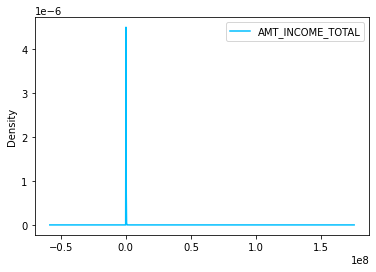

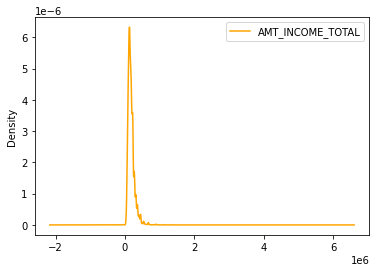

In [40]:
# plot the kde distribution of 'AMT_INCOME_TOTAL' of two sets
ax1=pd.DataFrame(dt_train_new['AMT_INCOME_TOTAL']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['AMT_INCOME_TOTAL']).plot(kind='kde',color='orange')

The training set has extremely large values and two distributions are not close. Delete these outliers so that the distributions of the two sets look similar. Here, by several attempts of deleting to make two distribution close, finally choose 6500000 as the threshold. The thresholds used on the following features are chosen in the same way.

(307506, 222)


<AxesSubplot:ylabel='Density'>

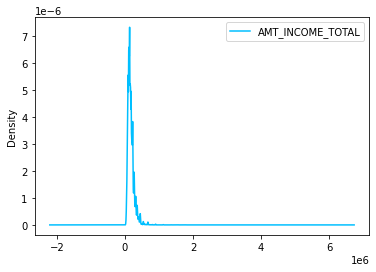

In [41]:
q1 = dt_train_new.drop(dt_train_new[dt_train_new['AMT_INCOME_TOTAL']>=6500000].index,axis=0)
print(q1.shape)  # 307506/307511
pd.DataFrame(q1['AMT_INCOME_TOTAL']).plot(kind='kde',color='deepskyblue')

Now the distributions of two series are similar.

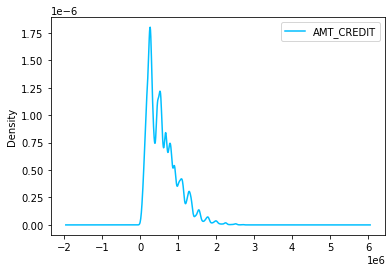

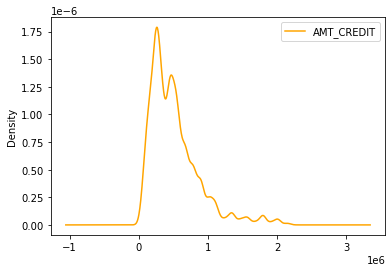

In [42]:
# plot the kde distribution of 'AMT_CREDIT' of two sets
ax1=pd.DataFrame(q1['AMT_CREDIT']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['AMT_CREDIT']).plot(kind='kde',color='orange')

(307378, 222)


<AxesSubplot:ylabel='Density'>

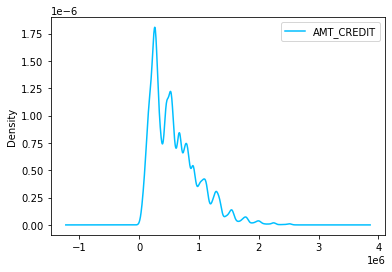

In [43]:
q2 = q1.drop(q1[q1['AMT_CREDIT']>=2600000].index,axis=0)
print(q2.shape)
pd.DataFrame(q2['AMT_CREDIT']).plot(kind='kde',color='deepskyblue')

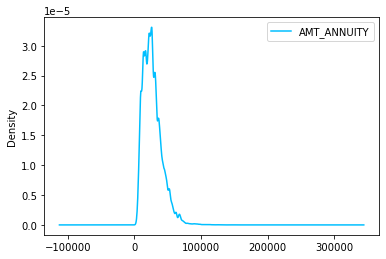

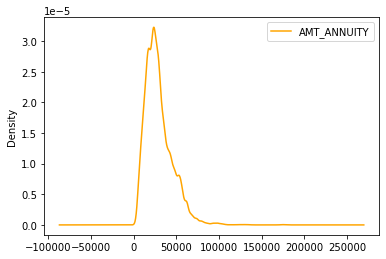

In [44]:
# plot the kde distribution of 'AMT_ANNUITY' of two sets
ax1=pd.DataFrame(q2['AMT_ANNUITY']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['AMT_ANNUITY']).plot(kind='kde',color='orange')

(307339, 222)


<AxesSubplot:ylabel='Density'>

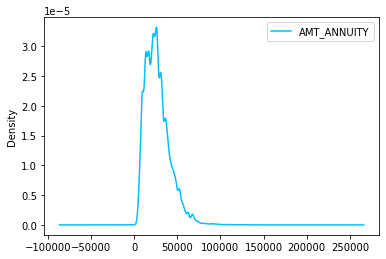

In [45]:
q3 = q2.drop(q2[q2['AMT_ANNUITY']>=180000].index,axis=0)
print(q3.shape)
pd.DataFrame(q3['AMT_ANNUITY']).plot(kind='kde',color='deepskyblue')

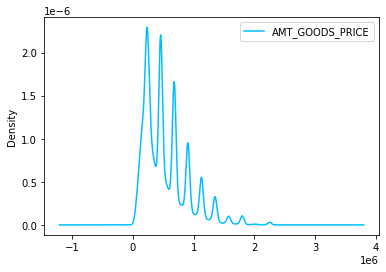

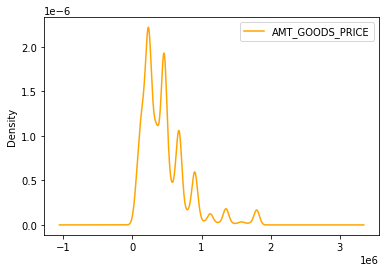

In [46]:
# plot the kde distribution of 'AMT_GOODS_PRICE' of two sets
ax1=pd.DataFrame(q3['AMT_GOODS_PRICE']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['AMT_GOODS_PRICE']).plot(kind='kde',color='orange')

(306409, 222)


<AxesSubplot:ylabel='Density'>

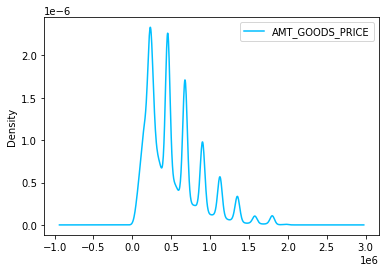

In [47]:
q4 = q3.drop(q3[q3['AMT_GOODS_PRICE']>=2000000].index,axis=0)
print(q4.shape)
pd.DataFrame(q4['AMT_GOODS_PRICE']).plot(kind='kde',color='deepskyblue')

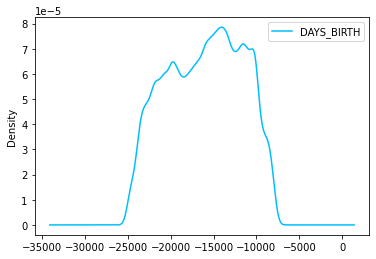

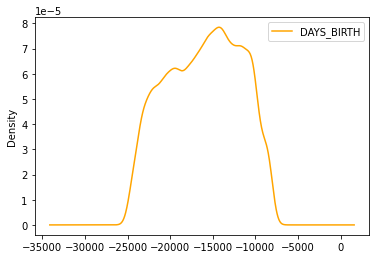

In [48]:
# plot the kde distribution of 'DAYS_BIRTH' of two sets
ax1=pd.DataFrame(q4['DAYS_BIRTH']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_BIRTH']).plot(kind='kde',color='orange')

The distributions are already similar so there is no need to process. Transform raw days_birth values to yearly values by divided -365, so that the value is as the normal range.

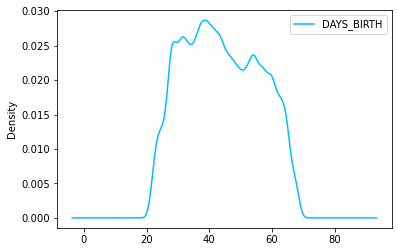

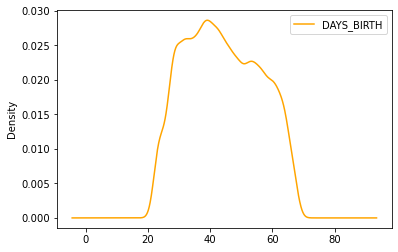

In [49]:
q4['DAYS_BIRTH']=(q4['DAYS_BIRTH'] / -365)
dt_test_new['DAYS_BIRTH']=(dt_test_new['DAYS_BIRTH']/ -365)
ax1=pd.DataFrame(q4['DAYS_BIRTH']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_BIRTH']).plot(kind='kde',color='orange')

The value range is now from 0 to 80.

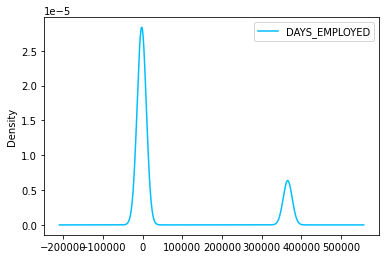

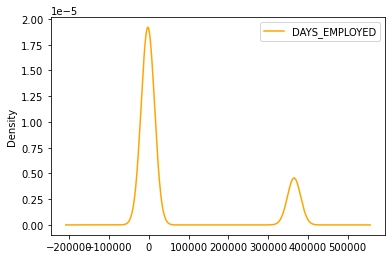

In [50]:
# plot the kde distribution of 'DAYS_EMPLOYED' of two sets
ax1=pd.DataFrame(q4['DAYS_EMPLOYED']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_EMPLOYED']).plot(kind='kde',color='orange')

In [51]:
dt_test_new['DAYS_EMPLOYED'].describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [52]:
q4['DAYS_EMPLOYED'][q4['DAYS_EMPLOYED']==365243]= -1212
dt_test_new['DAYS_EMPLOYED'][dt_test_new['DAYS_EMPLOYED']==365243]= -1293

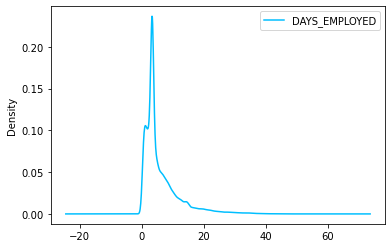

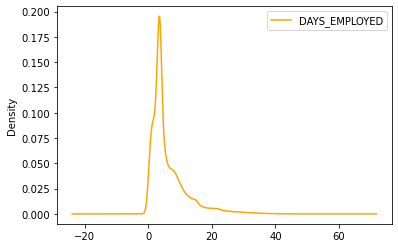

In [53]:
q4['DAYS_EMPLOYED']=(q4['DAYS_EMPLOYED'] / -365)
dt_test_new['DAYS_EMPLOYED']=(dt_test_new['DAYS_EMPLOYED']/ -365)
ax1=pd.DataFrame(q4['DAYS_EMPLOYED']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_EMPLOYED']).plot(kind='kde',color='orange')

There is an error value in 'DAYS_EMPLOYED': the maximum value is 365243. Replace this value by median (train set median: -1212; test set median: -1293). Also, transform the data to normal age range by dividing -365.

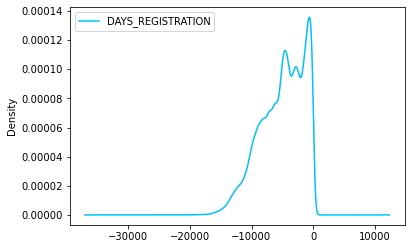

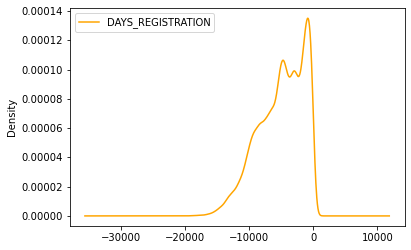

In [54]:
# plot the kde distribution of 'DAYS_REGISTRATION' of two sets
ax1=pd.DataFrame(q4['DAYS_REGISTRATION']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_REGISTRATION']).plot(kind='kde',color='orange')

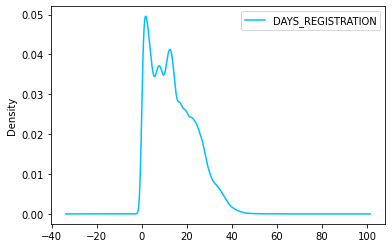

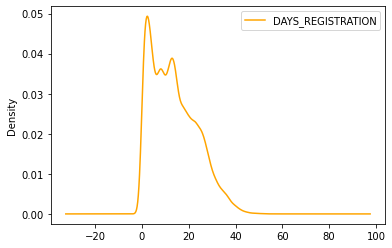

In [55]:
q4['DAYS_REGISTRATION']=(q4['DAYS_REGISTRATION'] / -365)
dt_test_new['DAYS_REGISTRATION']=(dt_test_new['DAYS_REGISTRATION']/ -365)
ax1=pd.DataFrame(q4['DAYS_REGISTRATION']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_REGISTRATION']).plot(kind='kde',color='orange')

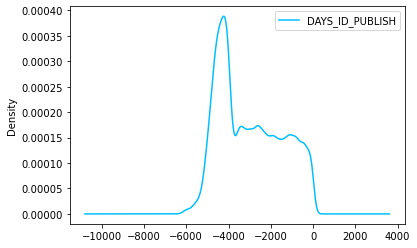

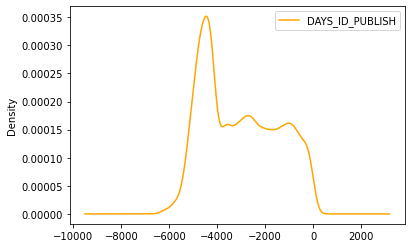

In [56]:
# plot the kde distribution of 'DAYS_ID_PUBLISH' of two sets
ax1=pd.DataFrame(q4['DAYS_ID_PUBLISH']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_ID_PUBLISH']).plot(kind='kde',color='orange')

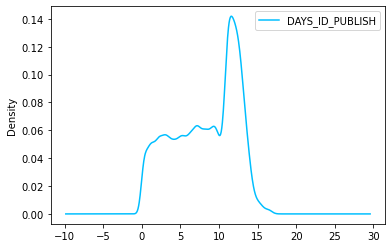

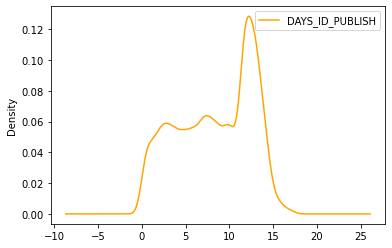

In [57]:
q4['DAYS_ID_PUBLISH']=(q4['DAYS_ID_PUBLISH'] / -365)
dt_test_new['DAYS_ID_PUBLISH']=(dt_test_new['DAYS_ID_PUBLISH']/ -365)
ax1=pd.DataFrame(q4['DAYS_ID_PUBLISH']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_ID_PUBLISH']).plot(kind='kde',color='orange')

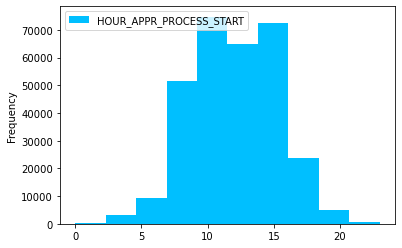

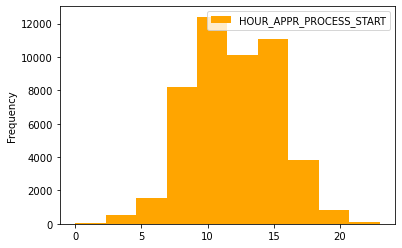

In [58]:
# plot the kde distribution of 'HOUR_APPR_PROCESS_START' of two sets
ax1=pd.DataFrame(q4['HOUR_APPR_PROCESS_START']).plot(kind='hist',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['HOUR_APPR_PROCESS_START']).plot(kind='hist',color='orange')

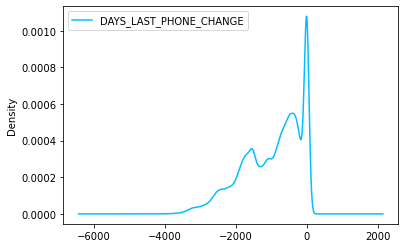

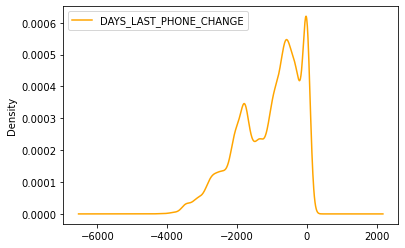

In [59]:
# plot the kde distribution of 'DAYS_LAST_PHONE_CHANGE' of two sets
ax1=pd.DataFrame(q4['DAYS_LAST_PHONE_CHANGE']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_LAST_PHONE_CHANGE']).plot(kind='kde',color='orange')

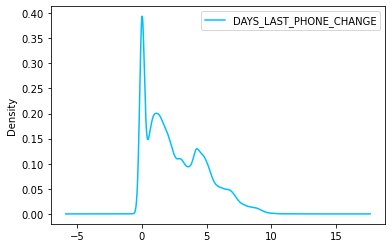

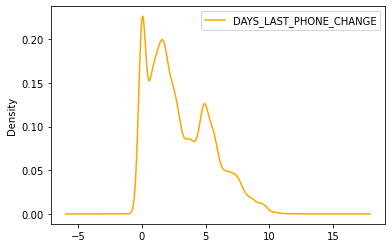

In [60]:
q4['DAYS_LAST_PHONE_CHANGE']=(q4['DAYS_LAST_PHONE_CHANGE'] / -365)
dt_test_new['DAYS_LAST_PHONE_CHANGE']=(dt_test_new['DAYS_LAST_PHONE_CHANGE']/ -365)
ax1=pd.DataFrame(q4['DAYS_LAST_PHONE_CHANGE']).plot(kind='kde',color='deepskyblue')
ax2=pd.DataFrame(dt_test_new['DAYS_LAST_PHONE_CHANGE']).plot(kind='kde',color='orange')

The distributions of train and test series of 'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','HOUR_APPR_PROCESS_START','DAYS_LAST_PHONE_CHANGE' are already similar so there is no need to process. Just transform them to normal range by dividing -365.

In [61]:
dt_train_new = q4
print(dt_train_new.shape,dt_test_new.shape)

(306409, 222) (48744, 218)


After deleting outliers, the number of samples for trainning set reduces about one thousand.

In [62]:
# interact train and test set with the same features.
dt_train, dt_test = dt_train_new.align(dt_test_new, join = 'inner', axis = 1) 
# add labels to the final train set.
train_labels = dt_train_new['TARGET'] 
dt_train['TARGET'] = train_labels 
print('Training Set shape: ', dt_train.shape) 
print('Testing Set shape: ', dt_test.shape)

Training Set shape:  (306409, 219)
Testing Set shape:  (48744, 218)


Use common features in two sets as the formal features in model. Now we have 218 features.

## 3.  Feature engneering
### 3.1 Add ratio features
With the help of references, I add some ratios that may contribute to the predication of labels. For example, 'AMT_CREDIT' is the credit amount of the loan, and 'AMT_INCOME_TOTAL' is the income of the client. The ratio of these is similar to the debt-to-income ratio (DTI), which could help to determine if one can afford to repay a loan. Generally, clients with higher DTI ratios are riskier borrowers, because they might have trouble repaying their loan in case of financial hardship.

In [63]:
dt_train['CREDIT_INCOME_RATIO'] = dt_train['AMT_CREDIT'] / dt_train['AMT_INCOME_TOTAL']
dt_train['ANNUITY_INCOME_RATIO'] = dt_train['AMT_ANNUITY'] / dt_train['AMT_INCOME_TOTAL']
dt_train['ANNUITY_CREDIT_RATIO'] = dt_train['AMT_ANNUITY'] / dt_train['AMT_CREDIT']
dt_train['DAYS_EMPLOYED_RATIO'] = dt_train['DAYS_EMPLOYED'] / dt_train['DAYS_BIRTH']
dt_train['AGE_STRAT_EMPLOYED'] = dt_train['DAYS_BIRTH'] - dt_train['DAYS_EMPLOYED']


dt_test['CREDIT_INCOME_RATIO'] = dt_test['AMT_CREDIT'] / dt_test['AMT_INCOME_TOTAL']
dt_test['ANNUITY_INCOME_RATIO'] = dt_test['AMT_ANNUITY'] / dt_test['AMT_INCOME_TOTAL']
dt_test['ANNUITY_CREDIT_RATIO'] = dt_test['AMT_ANNUITY'] / dt_test['AMT_CREDIT']
dt_test['DAYS_EMPLOYED_RATIO'] = dt_test['DAYS_EMPLOYED'] / dt_test['DAYS_BIRTH']
dt_test['AGE_STRAT_EMPLOYED'] = dt_test['DAYS_BIRTH'] - dt_test['DAYS_EMPLOYED']

print(dt_train.shape,dt_test.shape)

(306409, 224) (48744, 223)


### 3.2  Correlation analysis

In [64]:
correlations = dt_train.corr()['TARGET'].sort_values()

In [65]:
correlations.head(10)

EXT_SOURCE_2                           -0.160125
EXT_SOURCE_3                           -0.155794
EXT_SOURCE_1                           -0.098719
DAYS_BIRTH                             -0.078392
DAYS_EMPLOYED                          -0.058869
NAME_EDUCATION_TYPE_Higher education   -0.056095
DAYS_LAST_PHONE_CHANGE                 -0.055566
CODE_GENDER_F                          -0.055048
DAYS_ID_PUBLISH                        -0.051618
AGE_STRAT_EMPLOYED                     -0.046637
Name: TARGET, dtype: float64

For negative correlation, EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, DAYS_BIRTH, DAYS_EMPLOYED are the top 5 features.

In [66]:
correlations.tail(10)

FLAG_DOCUMENT_3                                      0.044324
REG_CITY_NOT_LIVE_CITY                               0.044463
FLAG_EMP_PHONE                                       0.046128
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049378
REG_CITY_NOT_WORK_CITY                               0.051008
CODE_GENDER_M                                        0.055056
NAME_INCOME_TYPE_Working                             0.057195
REGION_RATING_CLIENT                                 0.058445
REGION_RATING_CLIENT_W_CITY                          0.060463
TARGET                                               1.000000
Name: TARGET, dtype: float64

For positive correlation, REGION_RATING_CLIENT_W_CITY, REGION_RATING_CLIENT, NAME_INCOME_TYPE_Working, CODE_GENDER_M, REG_CITY_NOT_WORK_CITY are the top 5 features.

In [67]:
corr_top10 = dt_train[['TARGET', 'CODE_GENDER_F','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'NAME_EDUCATION_TYPE_Higher education',
                  'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT', 'NAME_INCOME_TYPE_Working','DAYS_LAST_PHONE_CHANGE']] 
corr_top10_corrs = corr_top10.corr() 

<Figure size 720x432 with 0 Axes>

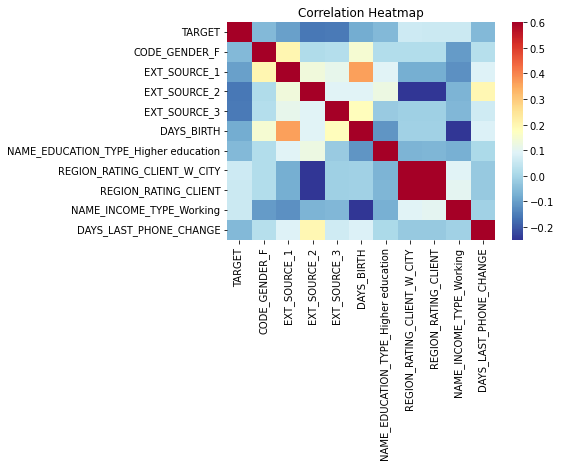

<Figure size 720x432 with 0 Axes>

In [68]:
sns.heatmap(corr_top10_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, vmax = 0.6)
plt.title('Correlation Heatmap'); 
plt.figure(figsize = (10, 6))

## 4. Model construction and prediction
### 4.1  Scale and split data to the model

In [69]:
# training and testing index
train_index = dt_train['SK_ID_CURR']
test_index = dt_test['SK_ID_CURR']
# training features
train_features = dt_train.drop(columns = ['SK_ID_CURR', 'TARGET'])
# training labels
train_labels = dt_train['TARGET']
# testing features
test_features = dt_test.drop(columns = ['SK_ID_CURR'])

print (train_features.shape,test_features.shape)

(306409, 222) (48744, 222)


In [70]:
train_features

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                        0             0                1             0   
1                        0             0                0             0   
2                        1             1                1             0   
3                        0             0                1             0   
4                        0             0                1             0   
...                    ...           ...              ...           ...   
307506                   0             0                0             0   
307507                   0             0                1             0   
307508                   0             0                1             0   
307509                   0             0                1             0   
307510                   0             0                0             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               202500.0    406597.5      24700.5         351000.0   
1               270000.0   1293502.5      35698.5        1129500.0   
2                67500.0    135000.0       6750.0         135000.0   
3               135000.0    312682.5      29686.5         297000.0   
4               121500.0    513000.0      21865.5         513000.0   
...                  ...         ...          ...              ...   
307506          157500.0    254700.0      27558.0         225000.0   
307507           72000.0    269550.0      12001.5         225000.0   
307508          153000.0    677664.0      29979.0         585000.0   
307509          171000.0    370107.0      20205.0         319500.0   
307510          157500.0    675000.0      49117.5         675000.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  ...  \
0                         0.018801   25.920548  ...   
1                         0.003541   45.931507  ...   
2                         0.010032   52.180822  ...   
3                         0.008019   52.068493  ...   
4                         0.028663   54.608219  ...   
...                            ...         ...  ...   
307506                    0.032561   25.553425  ...   
307507                    0.025164   56.917808  ...   
307508                    0.005002   41.002740  ...   
307509                    0.005313   32.769863  ...   
307510                    0.046220   46.180822  ...   

        WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                                   0                          0   
1                                   0                          0   
2                                   0                          0   
3                                   0                          0   
4                                   0                          0   
...                               ...                        ...   
307506                              0                          0   
307507                              0                          0   
307508                              0                          0   
307509                              0                          0   
307510                              0                          0   

        WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                              0                                1   
1                              0                                0   
2                              1                                0   
3                              1                                0   
4                              1                                0   
...                          ...                              ...   
307506                         0                                1   
307507                         0                                1   
307508                         1                                0   
307509                         0                                1   
307510                       

In [71]:
feature_name = train_features.columns
feature_name

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'CREDIT_INCOME_RATIO',
       'ANNUITY_INCOME_RATIO', 'ANNUITY_CREDIT_RATIO', 'DAYS_EMPLOYED_RATIO',
       'AGE_STRAT_EMPLOYED'],
      dtype='object', length=222)

Drop 'SK_ID_CURR' and 'TARGET' in training set, and use the remaining features as training features, say x_train. Drop 'SK_ID_CURR' in testing set, and use the remaining features as testing features, say x_test.
Use 'TARGET' as the response in regression model, say y_train.
Now we have 222 features.

In [72]:
# Min-Max scaler the data
min_max_scaler=preprocessing.MinMaxScaler()
train_features=min_max_scaler.fit_transform(train_features)
test_features=min_max_scaler.fit_transform(test_features)

In [119]:
# split train_features to training and validation data set. The ratio of two sets is 4:1
x_train, x_vali, y_train, y_vali = train_test_split(train_features, train_labels, test_size=0.2, random_state=2)
print(x_train.shape,x_vali.shape,y_train.shape,y_vali.shape)

(245127, 222) (61282, 222) (245127,) (61282,)


### 4.2 Logistic regression

In [113]:
# fit logistic regression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

Using probability as outputs is also a method in logistic regression.

In [114]:
# output is the probability, not 0 or 1
log_y_pred_pro = logreg.predict_proba(x_vali)[:,1]
# AUC score
log_valid_auc = roc_auc_score(y_vali, log_y_pred_pro) 
print(log_valid_auc)

0.7542966720553451


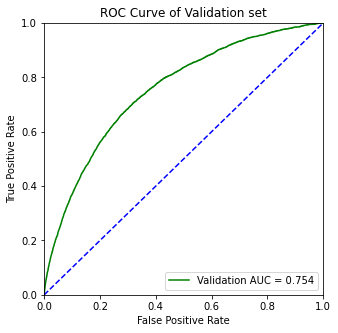

In [76]:
# plot the curve of AUC
fpr, tpr, threshold = metrics.roc_curve(y_vali, log_y_pred_pro) 
roc_auc = metrics.auc(fpr, tpr) 
plt.figure(figsize=(5,5)) 
plt.title('ROC Curve of Validation set') 
plt.plot(fpr, tpr, 'g', label = 'Validation AUC = %0.3f' % roc_auc) 
plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'b--') 
plt.xlim([0, 1])
plt.ylim([0, 1]) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.show()

The AUC score is higher than the binary classfier.

In [77]:
pd.DataFrame(log_y_pred_pro[log_y_pred_pro>0.5]).count()

0    124
dtype: int64

In [78]:
# change threshold to make prediction binary
log_y_pred_pro[log_y_pred_pro>0.5]=1
log_y_pred_pro[log_y_pred_pro<=0.5]=0

In [79]:
# new AUC
log_valid_auc = roc_auc_score(y_vali, log_y_pred_pro) 
print(log_valid_auc)
print(classification_report(y_vali, log_y_pred_pro))

0.5059505575098886
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56346
           1       0.52      0.01      0.03      4936

    accuracy                           0.92     61282
   macro avg       0.72      0.51      0.49     61282
weighted avg       0.89      0.92      0.88     61282



The precision for target 0 is 92.0% and for target 1 is 52% and AUC score is 0.51. For TARGET=0, all precision, recall and f1-score are very high, but for TARGET=1, the results are not good. That is because most predictions are predicting TARGET to be 0, so that few outputs are 1. The distribution for the training labels is imbalance, so machine tends to give more 0 target to get a higher accuracy. Binary classifier for this problem seems unpropriate.  

Text(33.0, 0.5, 'true')

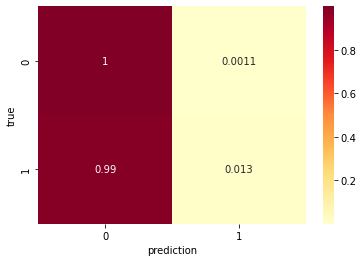

In [80]:
# plot the confusion matrix
cm=metrics.confusion_matrix(y_vali, log_y_pred_pro,normalize='true')
s=sns.heatmap(cm,annot=True,cmap='YlOrRd')
s.set_xlabel('prediction', fontsize=10)
s.set_ylabel('true', fontsize=10)

In [81]:
log_y_pred_pro = logreg.predict_proba(x_vali)[:,1]
# change threshold to make prediction binary
log_y_pred_pro[log_y_pred_pro>0.1]=1
log_y_pred_pro[log_y_pred_pro<=0.1]=0
print(classification_report(y_vali, log_y_pred_pro))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85     56346
           1       0.19      0.60      0.28      4936

    accuracy                           0.76     61282
   macro avg       0.57      0.69      0.57     61282
weighted avg       0.89      0.76      0.81     61282



Text(33.0, 0.5, 'true')

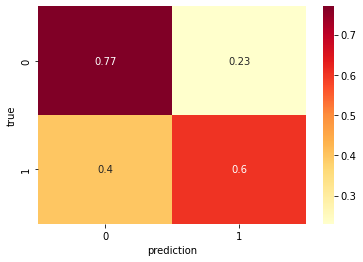

In [82]:
# plot the confusion matrix
cm=metrics.confusion_matrix(y_vali, log_y_pred_pro,normalize='true')
s=sns.heatmap(cm,annot=True,cmap='YlOrRd')
s.set_xlabel('prediction', fontsize=10)
s.set_ylabel('true', fontsize=10)

Changing the classfier threshold to 0.1, that is, if prediction value is larger than 0.1, see it as 1, otherwise 0. The recall improves a lot from 1.3% to 60%. Meanwhile, the recall for target 1 decrease from 1 to 77%. So I manually choose thresholds to try to make a tradeoff.

In [115]:
feature_name = dt_train.columns
feature_name = feature_name.drop(['SK_ID_CURR','TARGET'])
# the weight of the regression
w = logreg.coef_[0]

In [84]:
feature_importance = pd.DataFrame(feature_name,columns=['features'])
feature_importance['importance']=w
feature_importance = feature_importance.sort_values(by=['importance'],ascending=False)

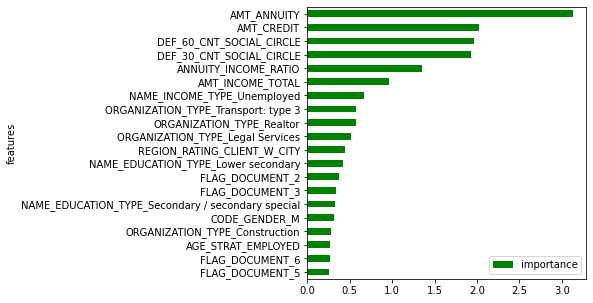

In [85]:
ax = feature_importance.head(20).sort_values(by=['importance'],ascending=True).plot.barh(x='features',y='importance',color='green',figsize=(5,5))
plt.show()

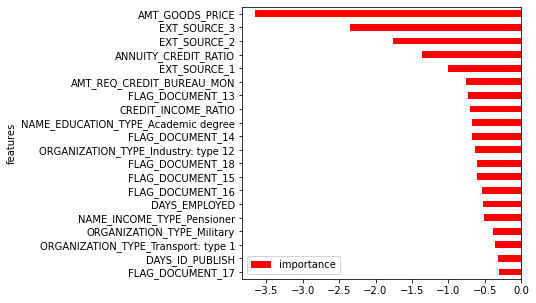

In [86]:
ax = feature_importance.tail(20).sort_values(by=['importance'],ascending=False).plot.barh(x='features',y='importance',color='red',figsize=(5,5))
plt.show()

In [87]:
feature_importance.head(20)

features  importance
6                                          AMT_ANNUITY    3.134397
5                                           AMT_CREDIT    2.018911
64                            DEF_60_CNT_SOCIAL_CIRCLE    1.960392
62                            DEF_30_CNT_SOCIAL_CIRCLE    1.930205
218                               ANNUITY_INCOME_RATIO    1.348408
4                                     AMT_INCOME_TOTAL    0.956610
106                        NAME_INCOME_TYPE_Unemployed    0.663428
203                ORGANIZATION_TYPE_Transport: type 3    0.577688
185                          ORGANIZATION_TYPE_Realtor    0.574184
178                   ORGANIZATION_TYPE_Legal Services    0.512730
21                         REGION_RATING_CLIENT_W_CITY    0.441467
111                NAME_EDUCATION_TYPE_Lower secondary    0.420595
66                                     FLAG_DOCUMENT_2    0.372702
67                                     FLAG_DOCUMENT_3    0.338990
112  NAME_EDUCATION_TYPE_Secondary / secondary special    0.322946
93                                       CODE_GENDER_M    0.311531
156                     ORGANIZATION_TYPE_Construction    0.283001
221                                 AGE_STRAT_EMPLOYED    0.266964
70                                     FLAG_DOCUMENT_6    0.260799
69                                     FLAG_DOCUMENT_5    0.259082

In [88]:
feature_importance.tail(20)

features  importance
81                      FLAG_DOCUMENT_17   -0.305191
12                       DAYS_ID_PUBLISH   -0.315446
201  ORGANIZATION_TYPE_Transport: type 1   -0.362746
180           ORGANIZATION_TYPE_Military   -0.383559
103           NAME_INCOME_TYPE_Pensioner   -0.508177
10                         DAYS_EMPLOYED   -0.521527
80                      FLAG_DOCUMENT_16   -0.539034
79                      FLAG_DOCUMENT_15   -0.608885
82                      FLAG_DOCUMENT_18   -0.611421
166  ORGANIZATION_TYPE_Industry: type 12   -0.636826
78                      FLAG_DOCUMENT_14   -0.673795
108  NAME_EDUCATION_TYPE_Academic degree   -0.678657
217                  CREDIT_INCOME_RATIO   -0.709116
77                      FLAG_DOCUMENT_13   -0.729162
89             AMT_REQ_CREDIT_BUREAU_MON   -0.763134
29                          EXT_SOURCE_1   -1.011040
219                 ANNUITY_CREDIT_RATIO   -1.360456
30                          EXT_SOURCE_2   -1.754945
31                          EXT_SOURCE_3   -2.350010
7                        AMT_GOODS_PRICE   -3.648020

In [89]:
# predict
log_y_test_pred_pro = logreg.predict_proba(test_features)[:,1]
output=pd.DataFrame(log_y_test_pred_pro)
output.index=test_index
output.columns=['TARGET']
# output.to_csv('./output/logi_maxmin_222feature_prob_May1.csv')

What if select important features involved in the model? That is, reduce the number of predictors. Sort the absolute values of the coefficients of features and select the largest 100 features.

In [90]:
feature_list=abs(feature_importance['importance']).sort_values(ascending=False)[:100].index
feature_list

Int64Index([  7,   6,  31,   5,  64,  62,  30, 219, 218,  29,   4,  89,  77,
            217, 108,  78, 106, 166,  82,  79, 203, 185,  80,  10, 178, 103,
             21, 111, 180,  66, 201,  67, 112,  12,  93,  81,  65,  88, 172,
            199, 156, 175, 197,  90, 221,   1,   9,  52,  70,  54,  69, 151,
             53, 195, 220, 171,  75,  13,  11,  61,  63,  23,  16,  73, 206,
            190,  25, 155, 133,  83,  19,   3, 124, 183, 184,  59, 191,  26,
             49,  87, 163, 193,  55, 121, 149,  15, 120, 161,  46,  33,  35,
             72,  24,  84,  20, 213, 140, 128, 205,  86],
           dtype='int64')

In [122]:
feature_name[feature_list]

Index(['AMT_GOODS_PRICE', 'AMT_ANNUITY', 'EXT_SOURCE_3', 'AMT_CREDIT',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'ANNUITY_CREDIT_RATIO', 'ANNUITY_INCOME_RATIO', 'EXT_SOURCE_1',
       'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_MON', 'FLAG_DOCUMENT_13',
       'CREDIT_INCOME_RATIO', 'NAME_EDUCATION_TYPE_Academic degree',
       'FLAG_DOCUMENT_14', 'NAME_INCOME_TYPE_Unemployed',
       'ORGANIZATION_TYPE_Industry: type 12', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_15', 'ORGANIZATION_TYPE_Transport: type 3',
       'ORGANIZATION_TYPE_Realtor', 'FLAG_DOCUMENT_16', 'DAYS_EMPLOYED',
       'ORGANIZATION_TYPE_Legal Services', 'NAME_INCOME_TYPE_Pensioner',
       'REGION_RATING_CLIENT_W_CITY', 'NAME_EDUCATION_TYPE_Lower secondary',
       'ORGANIZATION_TYPE_Military', 'FLAG_DOCUMENT_2',
       'ORGANIZATION_TYPE_Transport: type 1', 'FLAG_DOCUMENT_3',
       'NAME_EDUCATION_TYPE_Secondary / secondary special', 'DAYS_ID_PUBLISH',
       'CODE_GENDER_M

In [91]:
train_features_nf=train_features[:,feature_list]
test_features_nf=test_features[:,feature_list]
x_train_nf, x_vali_nf, y_train_nf, y_vali_nf = train_test_split(train_features_nf, train_labels, test_size=0.2, random_state=2)
print(x_train_nf.shape,x_vali_nf.shape,y_train_nf.shape,y_vali_nf.shape)
#train_features_nf.shape

(245127, 100) (61282, 100) (245127,) (61282,)


In [121]:
import statsmodels.api as sm
log_md=sm.Logit(y_train_nf,x_train_nf)
result=log_md.fit()
print(result.summary2())
#help(log_md)

         Current function value: 0.250206
         Iterations: 35


/Users/kuma/opt/anaconda3/envs/pytorch_envs/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.110      
Dependent Variable: TARGET           AIC:              122864.2477
Date:               2022-05-02 22:24 BIC:              123905.2009
No. Observations:   245127           Log-Likelihood:   -61332.    
Df Model:           99               LL-Null:          -68940.    
Df Residuals:       245027           LLR p-value:      0.0000     
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
           Coef.     Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------
x1          -5.2744    0.2813 -18.7473 0.0000    -5.8258   -4.7230
x2           1.8374    0.3303   5.5628 0.0000     1.1900    2.4847
x3          -2.3705    0.0384 -61.6618 0.0000    -2.4458   -2.2951
x4           4.4073  

In [93]:
logreg = LogisticRegression()
logreg.fit(x_train_nf, y_train_nf)
log_y_pred_pro_nf = logreg.predict_proba(x_vali_nf)[:,1]
log_valid_auc_nf = roc_auc_score(y_vali_nf, log_y_pred_pro_nf) 
print(log_valid_auc_nf)

0.7529439473901153


The AUC is smaller than the version without reducing features.

### 4.3  Lgb model

In [94]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=True) 
lgb_vali = lgb.Dataset(x_vali, y_vali) 
params = {'learning_rate':0.12, 'num_boost_round':100} 
model = lgb.train(params, lgb_train,lgb_vali) 
lgb_y_pred =model.predict(x_vali) 
lgb_y_pred[lgb_y_pred<0]=0
lgb_valid_auc = roc_auc_score(y_vali, lgb_y_pred) 
print(lgb_valid_auc)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 245127, number of used features: 214
[LightGBM] [Info] Start training from score 0.081015
0.7660459877990473


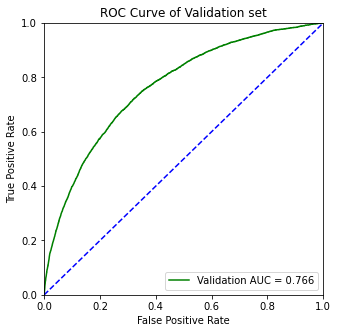

In [95]:
fpr, tpr, threshold = metrics.roc_curve(y_vali, lgb_y_pred) 
roc_auc = metrics.auc(fpr, tpr) 
plt.figure(figsize=(5,5)) 
plt.title('ROC Curve of Validation set') 
plt.plot(fpr, tpr, 'g', label = 'Validation AUC = %0.3f' % roc_auc) 
plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'b--') 
plt.xlim([0, 1])
plt.ylim([0, 1]) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.show()

In [96]:
pd.DataFrame(lgb_y_pred).describe()

0
count  61282.000000
mean       0.080946
std        0.078574
min        0.000000
25%        0.028925
50%        0.056359
75%        0.106490
max        0.798645

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56346
           1       0.52      0.02      0.03      4936

    accuracy                           0.92     61282
   macro avg       0.72      0.51      0.49     61282
weighted avg       0.89      0.92      0.88     61282



Text(33.0, 0.5, 'true')

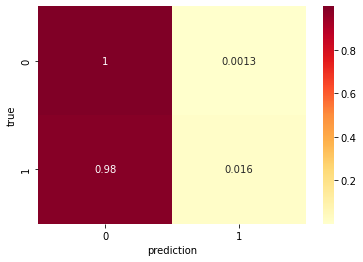

In [97]:
lgb_y_pred[lgb_y_pred>0.5]=1
lgb_y_pred[lgb_y_pred<=0.5]=0
print(classification_report(y_vali, lgb_y_pred))
cm=metrics.confusion_matrix(y_vali, lgb_y_pred,normalize='true')
s=sns.heatmap(cm,annot=True,cmap='YlOrRd')
s.set_xlabel('prediction', fontsize=10)
s.set_ylabel('true', fontsize=10)

              precision    recall  f1-score   support

           0       0.96      0.76      0.85     56346
           1       0.19      0.63      0.29      4936

    accuracy                           0.75     61282
   macro avg       0.57      0.70      0.57     61282
weighted avg       0.90      0.75      0.80     61282



Text(33.0, 0.5, 'true')

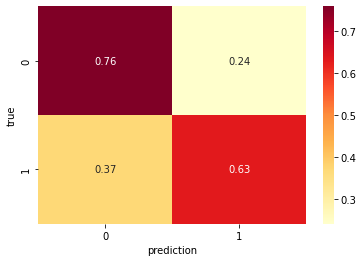

In [98]:
lgb_y_pred =model.predict(x_vali) 
lgb_y_pred[lgb_y_pred>0.1]=1
lgb_y_pred[lgb_y_pred<=0.1]=0
print(classification_report(y_vali, lgb_y_pred))
cm=metrics.confusion_matrix(y_vali, lgb_y_pred,normalize='true')
s=sns.heatmap(cm,annot=True,cmap='YlOrRd')
s.set_xlabel('prediction', fontsize=10)
s.set_ylabel('true', fontsize=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

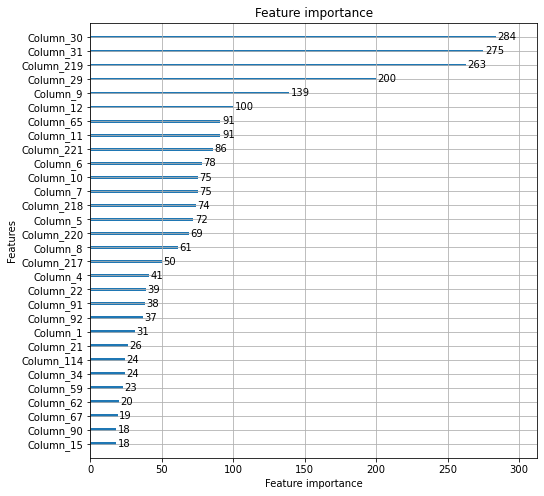

In [99]:
lgb.plot_importance(model,max_num_features=30,figsize=(8,8))

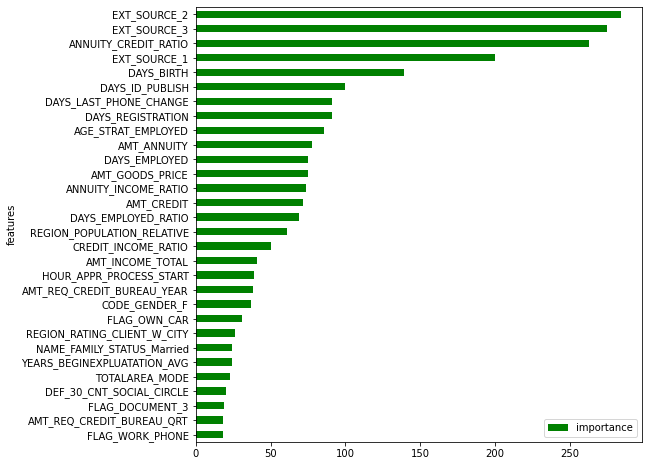

In [100]:
list_lgb=[30,31,219,29,9,12,65,11,221,6,10,7,218,5,220,8,217,4,22,91,92,1,21,114,34,59,62,67,90,15]
importance_lgb=[284,275,263,200,139,100,91,91,86,78,75,75,74,72,69,61,50,41,39,38,37,31,26,24,24,23,20,19,18,18]
feature_lgb_list=feature_name[list_lgb]
feature_importance_lgb = pd.DataFrame(feature_lgb_list,columns=['features'])
feature_importance_lgb['importance']=importance_lgb
ax = feature_importance_lgb.sort_values(by=['importance'],ascending=True).plot.barh(x='features',y='importance',color='green',figsize=(8,8))
plt.show()

In [101]:
lgb_y_test_pred_pro = model.predict(test_features)
output=pd.DataFrame(lgb_y_test_pred_pro)
output.index=test_index
output.columns=['TARGET']
output[output['TARGET']<0]=0
# output.to_csv('./output/lgb_222feature_May1.csv')

### 4.4  Lgb model with Focal loss

In [102]:
# define focal loss function
def focal_loss_lgb(y_pred, dt_train, alpha, gamma): 
    y_label = dt_train.label 
    def fl(x,t): 
        p = 1/(1+np.exp(-x)) 
        return -( alpha*t + (1-alpha)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**gamma) * ( t*np.log(p)+(1-t)*np.log(1-p) ) 
    plug_fl = lambda x: fl(x, y_label) 
    grad = derivative(plug_fl, y_pred, n=1, dx=1e-6) 
    hess = derivative(plug_fl, y_pred, n=2, dx=1e-6) 
    return grad, hess

In [103]:
# define focal loss validation error
def focal_loss_lgb_eval_error(y_pred, dt_train, alpha, gamma): 
    y_label = dt_train.label 
    p = 1/(1+np.exp(-y_pred)) 
    loss = -( alpha*y_label + (1-alpha)*(1-y_label) ) * (( 1 - ( y_label*p + (1-y_label)*(1-p)) )**gamma) * ( y_label*np.log(p)+(1-y_label)*np.log(1-p) ) 
    return 'focal_loss', np.mean(loss), False

In [104]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.96, 0.38) 
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.96, 0.38) 
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=True) 
lgb_vali = lgb.Dataset(x_vali, y_vali) 
params = {'learning_rate':0.1, 'num_boost_round':117} 
model = lgb.train(params, lgb_train, valid_sets=[lgb_vali], fobj=focal_loss, feval=eval_error )

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10005
[LightGBM] [Info] Number of data points in the train set: 245127, number of used features: 214
[LightGBM] [Warning] Using self-defined objective function
[1]	valid_0's focal_loss: 0.0587834
[2]	valid_0's focal_loss: 0.0571393
[3]	valid_0's focal_loss: 0.0557782
[4]	valid_0's focal_loss: 0.0546342
[5]	valid_0's focal_loss: 0.0536802
[6]	valid_0's focal_loss: 0.0528747
[7]	valid_0's focal_loss: 0.0521717
[8]	valid_0's focal_loss: 0.0515876
[9]	valid_0's focal_loss: 0.0510845
[10]	valid_0's focal_loss: 0.0506267
[11]	valid_0's focal_loss: 0.0502529
[12]	valid_0's focal_loss: 0.0499134
[13]	valid_0's focal_loss: 0.049622
[14]	valid_0's focal_loss: 0.0493534
[15]	valid_0's 

In [105]:
fllgb_y_pred =model.predict(x_vali) 
fllgb_y_pred=(fllgb_y_pred-fllgb_y_pred.min())/(fllgb_y_pred.max()-fllgb_y_pred.min())
fllgb_valid_auc = roc_auc_score(y_vali, fllgb_y_pred) 
print(fllgb_valid_auc)

0.7701586950527537


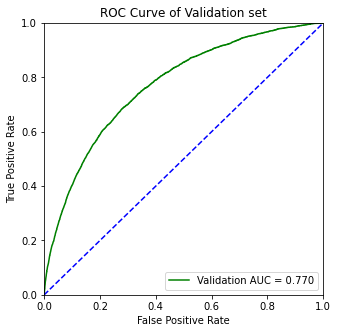

In [106]:
fpr, tpr, threshold = metrics.roc_curve(y_vali, fllgb_y_pred) 
roc_auc = metrics.auc(fpr, tpr) 
plt.figure(figsize=(5,5)) 
plt.title('ROC Curve of Validation set') 
plt.plot(fpr, tpr, 'g', label = 'Validation AUC = %0.3f' % roc_auc) 
plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'b--') 
plt.xlim([0, 1])
plt.ylim([0, 1]) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.26      0.42     56346
           1       0.10      0.95      0.18      4936

    accuracy                           0.32     61282
   macro avg       0.54      0.61      0.30     61282
weighted avg       0.91      0.32      0.40     61282



Text(33.0, 0.5, 'true')

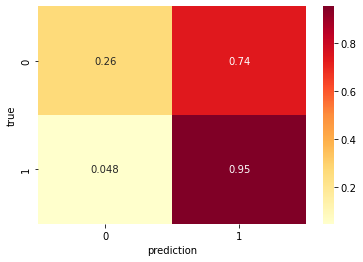

In [107]:
fllgb_y_pred[fllgb_y_pred>0.5]=1
fllgb_y_pred[fllgb_y_pred<=0.5]=0
print(classification_report(y_vali, fllgb_y_pred))
cm=metrics.confusion_matrix(y_vali, fllgb_y_pred,normalize='true')
s=sns.heatmap(cm,annot=True,cmap='YlOrRd')
s.set_xlabel('prediction', fontsize=10)
s.set_ylabel('true', fontsize=10)

Text(33.0, 0.5, 'true')

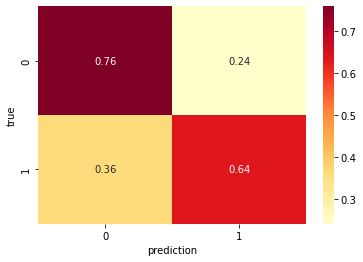

In [108]:
fllgb_y_pred =model.predict(x_vali) 
fllgb_y_pred=(fllgb_y_pred-fllgb_y_pred.min())/(fllgb_y_pred.max()-fllgb_y_pred.min())
fllgb_y_pred[fllgb_y_pred>0.695]=1
fllgb_y_pred[fllgb_y_pred<=0.695]=0

cm=metrics.confusion_matrix(y_vali, fllgb_y_pred,normalize='true')
s=sns.heatmap(cm,annot=True,cmap='YlOrRd')
s.set_xlabel('prediction', fontsize=10)
s.set_ylabel('true', fontsize=10)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

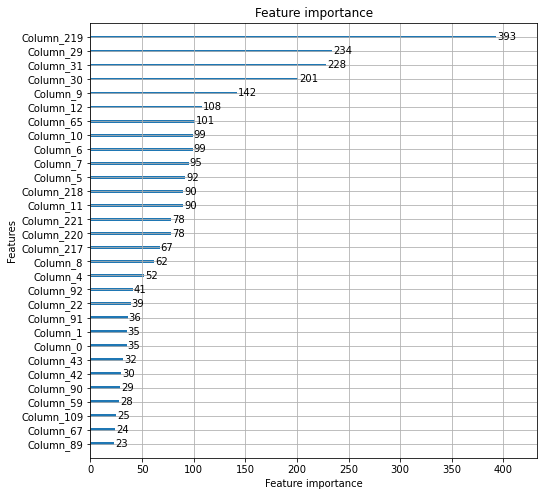

In [109]:
lgb.plot_importance(model,max_num_features=30,figsize=(8,8))

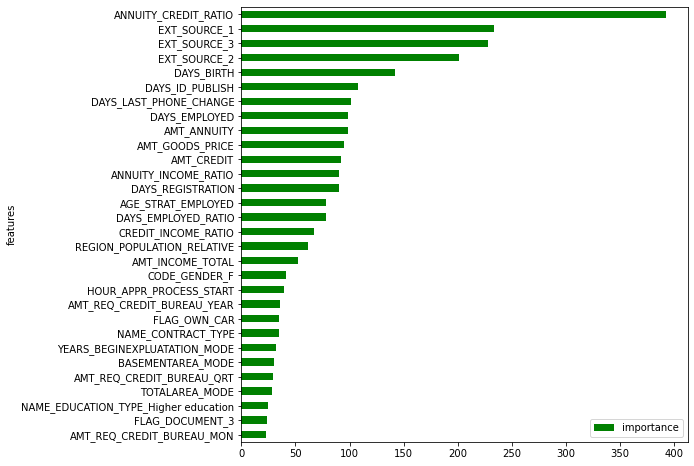

In [110]:
list_fllgb=[219,29,31,30,9,12,65,10,6,7,5,218,11,221,220,217,8,4,92,22,91,1,0,43,42,90,59,109,67,89]
importance_fllgb=[393,234,228,201,142,108,101,99,99,95,92,90,90,78,78,67,62,52,41,39,36,35,35,32,30,29,28,25,24,23]
feature_fllgb_list=feature_name[list_fllgb]
feature_importance_fllgb = pd.DataFrame(feature_fllgb_list,columns=['features'])
feature_importance_fllgb['importance']=importance_fllgb
ax = feature_importance_fllgb.sort_values(by=['importance'],ascending=True).plot.barh(x='features',y='importance',color='green',figsize=(8,8))
plt.show()

In [111]:
fllgb_y_test_pred_pro = model.predict(test_features)
fllgb_y_test_pred_pro=(fllgb_y_test_pred_pro-fllgb_y_test_pred_pro.min())/(fllgb_y_test_pred_pro.max()-fllgb_y_test_pred_pro.min())
output=pd.DataFrame(fllgb_y_test_pred_pro)
output.index=test_index
output.columns=['TARGET']
# output.to_csv('./output/fllgb_221feature_May1_2.csv')

In [112]:
output.describe()

TARGET
count  48744.000000
mean       0.546676
std        0.133738
min        0.000000
25%        0.452486
50%        0.546778
75%        0.641893
max        1.000000